# Load dataset and understand features

In [3]:
# imports for the project 

import time
import pickle
#import faiss
import pandas as pd
import numpy as np
import torch
import torchvision.utils
import torch.nn as nn
import torch.optim as torch_optim
from torch.utils.data import DataLoader, Dataset
import sys
sys.path.insert(1, '/kaggle/input/setup-file/')
from pytorchtools import EStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
path = '/kaggle/input/setup-file/'
full_data = pd.read_csv(path+"wustl_iiot_2021.csv")
print("wustl_iiot_2021 dataset loaded sucessfully")


wustl_iiot_2021 dataset loaded sucessfully


# Exploratory Data Analysis (EDA)

In [5]:
# Show first 5 rows
full_data.head()

,StartTime,LastTime,SrcAddr,DstAddr,Mean,Sport,Dport,SrcPkts,DstPkts,TotPkts,...,SAppBytes,DAppBytes,TotAppByte,SynAck,RunTime,sTos,SrcJitAct,DstJitAct,Traffic,Target
0,2019-08-19 12:23:28,2019-08-19 12:23:28,192.168.0.20,192.168.0.2,0,59034,502,10,8,18,...,24,20,44,0.001176,0.053037,0,0.000000,0.0,normal,0
1,2019-08-19 15:13:24,2019-08-19 15:13:24,192.168.0.20,192.168.0.2,0,55841,502,10,8,18,...,24,20,44,0.001308,0.052681,0,0.000000,0.0,normal,0
2,2019-08-19 13:41:31,2019-08-19 13:41:31,192.168.0.20,192.168.0.2,0,63774,502,10,8,18,...,24,20,44,0.000690,0.051793,0,0.000000,0.0,normal,0
3,2019-08-19 12:43:19,2019-08-19 12:43:20,209.240.235.92,192.168.0.2,0,61771,80,4,0,4,...,0,0,0,0.000000,0.889555,0,419.338813,0.0,DoS,1
4,2019-08-19 14:49:44,2019-08-19 14:49:48,192.168.0.20,192.168.0.1,3,0,0,14,0,14,...,476,0,476,0.000000,3.500055,0,525.146562,0.0,normal,0


In [6]:
full_data.nunique().sort_values()

Target              2
dTtl                3
sDSb                5
sTos                5
Traffic             5
Mean                6
Proto               8
SrcAddr            14
SrcLoss            68
DstAddr           132
DstLoss           135
Loss              152
IdleTime          200
sTtl              255
pLoss             274
DAppBytes         277
DstPkts           321
DstBytes          446
SAppBytes         468
SrcPkts           567
TotPkts           637
TotAppByte        933
SrcBytes         1592
TotBytes         1742
SynAck           4021
DstJitAct        4293
TcpRtt           4752
Dport            7781
StartTime       25267
LastTime        25276
sIpId           44717
DstRate         46482
Sport           51057
DIntPkt         53631
SrcJitAct       57226
dIpId           65536
DstLoad         65827
RunTime         81522
Max             81522
Min             81522
Sum             81522
Dur             81931
SrcRate         82185
SrcLoad         84158
Rate            89076
SIntPkt   

In [7]:
# Show unique class names and counts
print("Unique classes:", full_data['Traffic'].unique())
print("Number of unique classes:", full_data['Traffic'].nunique())
print("Class distribution:\n", full_data['Traffic'].value_counts())

Unique classes: ['normal' 'DoS' 'Reconn' 'Backdoor' 'CommInj']
Number of unique classes: 5
Class distribution:
 Traffic
normal      1107448
DoS           78305
Reconn         8240
CommInj         259
Backdoor        212
Name: count, dtype: int64


In [8]:
# Percentage distribution
class_percent = full_data['Traffic'].value_counts(normalize=True) * 100
print(class_percent)

Traffic
normal      92.715059
DoS          6.555660
Reconn       0.689849
CommInj      0.021683
Backdoor     0.017749
Name: proportion, dtype: float64


In [9]:
# Data types
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194464 entries, 0 to 1194463
Data columns (total 49 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   StartTime   1194464 non-null  object 
 1   LastTime    1194464 non-null  object 
 2   SrcAddr     1194464 non-null  object 
 3   DstAddr     1194464 non-null  object 
 4   Mean        1194464 non-null  int64  
 5   Sport       1194464 non-null  int64  
 6   Dport       1194464 non-null  int64  
 7   SrcPkts     1194464 non-null  int64  
 8   DstPkts     1194464 non-null  int64  
 9   TotPkts     1194464 non-null  int64  
 10  DstBytes    1194464 non-null  int64  
 11  SrcBytes    1194464 non-null  int64  
 12  TotBytes    1194464 non-null  int64  
 13  SrcLoad     1194464 non-null  float64
 14  DstLoad     1194464 non-null  float64
 15  Load        1194464 non-null  float64
 16  SrcRate     1194464 non-null  float64
 17  DstRate     1194464 non-null  float64
 18  Rate        1194464 no

In [10]:
print("Shape of dataset:", full_data.shape)
#print("\nData types:\n", full_data.dtypes)
print(full_data.columns)

Shape of dataset: (1194464, 49)
Index(['StartTime', 'LastTime', 'SrcAddr', 'DstAddr', 'Mean', 'Sport', 'Dport',
       'SrcPkts', 'DstPkts', 'TotPkts', 'DstBytes', 'SrcBytes', 'TotBytes',
       'SrcLoad', 'DstLoad', 'Load', 'SrcRate', 'DstRate', 'Rate', 'SrcLoss',
       'DstLoss', 'Loss', 'pLoss', 'SrcJitter', 'DstJitter', 'SIntPkt',
       'DIntPkt', 'Proto', 'Dur', 'TcpRtt', 'IdleTime', 'Sum', 'Min', 'Max',
       'sDSb', 'sTtl', 'dTtl', 'sIpId', 'dIpId', 'SAppBytes', 'DAppBytes',
       'TotAppByte', 'SynAck', 'RunTime', 'sTos', 'SrcJitAct', 'DstJitAct',
       'Traffic', 'Target'],
      dtype='object')


In [11]:
# data.describe() only summarizes numeric columns by default.
full_data.describe()

,Mean,Sport,Dport,SrcPkts,DstPkts,TotPkts,DstBytes,SrcBytes,TotBytes,SrcLoad,...,dIpId,SAppBytes,DAppBytes,TotAppByte,SynAck,RunTime,sTos,SrcJitAct,DstJitAct,Target
count,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,...,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06
mean,1.286870e-01,5.445253e+04,7.907604e+02,1.665579e+02,1.688389e+01,1.756631e+02,7.601579e+03,1.938043e+04,2.779692e+05,1.571207e+07,...,2.956785e+04,2.192527e+02,7.051507e+03,6.581117e+05,1.801930e-03,1.994698e-01,7.531412e-03,6.189383e+01,2.653724e-01,7.284941e-02
std,6.859156e-01,1.200834e+04,3.299492e+03,5.266192e+04,1.137763e+03,5.266221e+04,7.508699e+05,4.730229e+06,1.918939e+07,8.339078e+07,...,2.027684e+04,2.852114e+03,7.445876e+05,4.167380e+07,5.485539e-02,7.966451e-01,7.442284e-01,4.143742e+02,5.001929e+00,2.598893e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,5.221800e+04,5.020000e+02,1.000000e+01,8.000000e+00,1.800000e+01,5.080000e+02,6.440000e+02,1.152000e+03,8.514543e+04,...,1.117100e+04,2.400000e+01,2.000000e+01,4.400000e+01,6.310000e-04,5.134900e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,5.663500e+04,5.020000e+02,1.000000e+01,8.000000e+00,1.800000e+01,5.080000e+02,6.440000e+02,1.152000e+03,8.818777e+04,...,2.934000e+04,2.400000e+01,2.000000e+01,4.400000e+01,6.750000e-04,5.206700e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,6.104300e+04,5.020000e+02,1.000000e+01,8.000000e+00,1.800000e+01,5.080000e+02,6.440000e+02,1.152000e+03,8.968784e+04,...,4.686000e+04,2.400000e+01,2.000000e+01,4.400000e+01,8.020000e-04,5.324900e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.000000e+00,2.765721e+06,6.552200e+04,2.773967e+07,3.092160e+05,2.773967e+07,8.251559e+07,2.108646e+09,2.143725e+09,1.156000e+09,...,6.553500e+04,9.979300e+04,8.182314e+07,4.293700e+09,3.036730e+00,5.103213e+00,2.070000e+02,4.999440e+03,7.695150e+02,1.000000e+00


In [12]:
full_data.describe(include='all')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,StartTime,LastTime,SrcAddr,DstAddr,Mean,Sport,Dport,SrcPkts,DstPkts,TotPkts,...,SAppBytes,DAppBytes,TotAppByte,SynAck,RunTime,sTos,SrcJitAct,DstJitAct,Traffic,Target
count,1194464,1194464,1194464,1194464,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,...,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1.194464e+06,1194464,1.194464e+06
unique,25267,25276,14,132,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
top,2019-08-19 12:32:29,2019-08-19 12:29:43,192.168.0.20,192.168.0.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,NaN
freq,312,351,1090574,1155810,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1107448,NaN
mean,NaN,NaN,NaN,NaN,1.286870e-01,5.445253e+04,7.907604e+02,1.665579e+02,1.688389e+01,1.756631e+02,...,2.192527e+02,7.051507e+03,6.581117e+05,1.801930e-03,1.994698e-01,7.531412e-03,6.189383e+01,2.653724e-01,NaN,7.284941e-02
std,NaN,NaN,NaN,NaN,6.859156e-01,1.200834e+04,3.299492e+03,5.266192e+04,1.137763e+03,5.266221e+04,...,2.852114e+03,7.445876e+05,4.167380e+07,5.485539e-02,7.966451e-01,7.442284e-01,4.143742e+02,5.001929e+00,NaN,2.598893e-01
min,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,0.000000e+00,5.221800e+04,5.020000e+02,1.000000e+01,8.000000e+00,1.800000e+01,...,2.400000e+01,2.000000e+01,4.400000e+01,6.310000e-04,5.134900e-02,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
50%,NaN,NaN,NaN,NaN,0.000000e+00,5.663500e+04,5.020000e+02,1.000000e+01,8.000000e+00,1.800000e+01,...,2.400000e+01,2.000000e+01,4.400000e+01,6.750000e-04,5.206700e-02,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
75%,NaN,NaN,NaN,NaN,0.000000e+00,6.104300e+04,5.020000e+02,1.000000e+01,8.000000e+00,1.800000e+01,...,2.400000e+01,2.000000e+01,4.400000e+01,8.020000e-04,5.324900e-02,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00


In [13]:
full_data.select_dtypes(include='object').columns

Index(['StartTime', 'LastTime', 'SrcAddr', 'DstAddr', 'Traffic'], dtype='object')

In [14]:
# Unique classes
print("Unique classes in Traffic:", full_data['Traffic'].unique())
print("Number of unique classes:", full_data['Traffic'].nunique())

Unique classes in Traffic: ['normal' 'DoS' 'Reconn' 'Backdoor' 'CommInj']
Number of unique classes: 5


In [15]:
# Total missing values per column
missing_counts = full_data.isnull().sum().sort_values(ascending=False)
print(missing_counts)

StartTime     0
LastTime      0
SrcAddr       0
DstAddr       0
Mean          0
Sport         0
Dport         0
SrcPkts       0
DstPkts       0
TotPkts       0
DstBytes      0
SrcBytes      0
TotBytes      0
SrcLoad       0
DstLoad       0
Load          0
SrcRate       0
DstRate       0
Rate          0
SrcLoss       0
DstLoss       0
Loss          0
pLoss         0
SrcJitter     0
DstJitter     0
SIntPkt       0
DIntPkt       0
Proto         0
Dur           0
TcpRtt        0
IdleTime      0
Sum           0
Min           0
Max           0
sDSb          0
sTtl          0
dTtl          0
sIpId         0
dIpId         0
SAppBytes     0
DAppBytes     0
TotAppByte    0
SynAck        0
RunTime       0
sTos          0
SrcJitAct     0
DstJitAct     0
Traffic       0
Target        0
dtype: int64


In [16]:
print("Duplicate rows:", full_data.duplicated().sum())

Duplicate rows: 0


In [17]:

# Percentage of missing per column
missing_percent = (full_data.isnull().sum() / len(full_data)) * 100
missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_percent': missing_percent.sort_values(ascending=False)
})
missing_summary.head(20)

,missing_count,missing_percent
StartTime,0,0.0
LastTime,0,0.0
SrcAddr,0,0.0
DstAddr,0,0.0
Mean,0,0.0
Sport,0,0.0
Dport,0,0.0
SrcPkts,0,0.0
DstPkts,0,0.0
TotPkts,0,0.0


# Time-Based EDA (Extremely Important for IIoT)

In [18]:
full_data['StartTime'] = pd.to_datetime(full_data['StartTime'])
full_data['LastTime']  = pd.to_datetime(full_data['LastTime'])

full_data['FlowDuration'] = (full_data['LastTime'] - full_data['StartTime']).dt.total_seconds()

<Axes: xlabel='StartTime'>

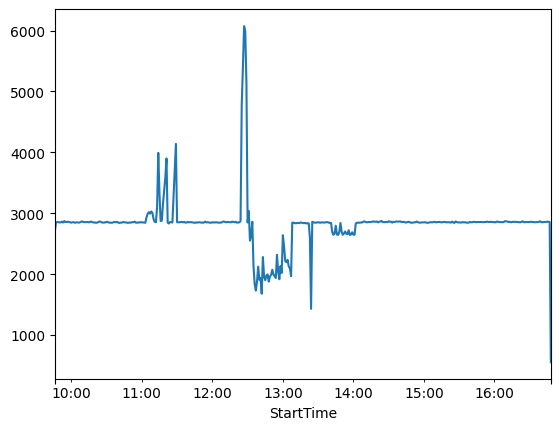

In [19]:
full_data.set_index('StartTime')['Target'].resample('1Min').count().plot()

<Axes: xlabel='StartTime'>

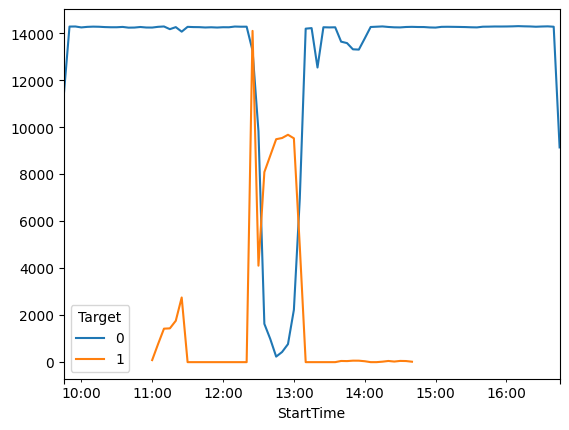

In [20]:
full_data.set_index('StartTime').groupby('Target').resample('5Min').size().unstack(0).plot()

# IP Address EDA (High-Value Insight)

In [21]:
full_data['SrcAddr'].nunique()


14

In [22]:
full_data['DstAddr'].nunique()

132

### Top attackers: 

In [23]:
full_data[full_data['Target'] == 1]['SrcAddr'].value_counts().head(10)

SrcAddr
209.240.235.92    46615
192.168.0.10      26797
20.1.249.77        7220
49.48.134.64       6320
192.168.0.2          37
192.168.0.20         27
Name: count, dtype: int64

### Top victims:

In [24]:
full_data[full_data['Target'] == 1]['DstAddr'].value_counts().head(10)

DstAddr
192.168.0.2     67233
192.168.0.20    19719
192.168.0.10       64
Name: count, dtype: int64

# Packet & Byte Behavior: Normal vs Attack

In [25]:
key_features = ['TotPkts', 'TotBytes', 'Rate', 'Load', 'pLoss', 'Dur']

full_data.groupby('Target')[key_features].mean().T

Target,0,1
TotPkts,1.846714e+02,6.101535e+01
TotBytes,2.920422e+05,9.886372e+04
Rate,4.911022e+03,3.705096e+05
Load,2.737613e+06,1.838821e+08
pLoss,1.882309e+01,3.688177e+01
Dur,8.080405e-01,1.461933e+00


# Protocol & Port Analysis (Attack Fingerprints)

In [26]:
full_data.groupby(['Proto', 'Target']).size().unstack()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Target,0,1
Proto,,
0,423.0,NaN
1,NaN,9.0
2,135.0,NaN
6,1085188.0,68767.0
17,10806.0,18159.0
58,35.0,NaN
2054,8332.0,81.0
35020,2529.0,NaN


In [27]:
full_data[full_data['Target'] == 1]['Dport'].value_counts().head(20)

Dport
80       52935
502      18379
8080      7221
5555       154
0           81
35072        9
137          9
41743        3
55464        3
27769        3
30759        3
54079        3
72           3
22164        3
61533        3
9231         3
58371        2
496          2
29901        2
46876        2
Name: count, dtype: int64

# Skewness & Log Transform

In [28]:
full_data[['TotBytes','Rate','Load','Dur']].skew()

TotBytes     81.039053
Rate          5.452961
Load          5.435630
Dur         792.159465
dtype: float64

# Multi-Class Attack EDA (Traffic)

In [29]:
full_data.groupby('Traffic')[['TotPkts','Rate','Load','Dur']].mean()

,TotPkts,Rate,Load,Dur
Traffic,,,,
Backdoor,9552.226415,42493.207977,8.014177e+07,2.956205
CommInj,6243.088803,53393.484097,1.796334e+07,3.814396
DoS,21.011072,367025.642520,1.820521e+08,1.603810
Reconn,2.670874,422025.079805,2.091567e+08,0.001285
normal,184.671351,4911.022207,2.737613e+06,0.808041


# 1. Categorical Data

### a. Countplot

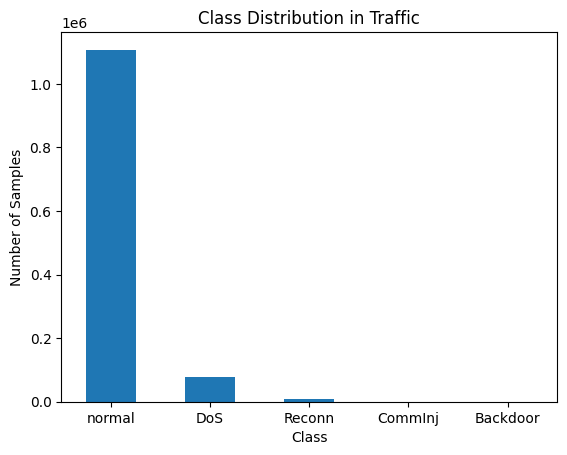

In [30]:
full_data['Traffic'].value_counts().plot(kind='bar')
plt.title("Class Distribution in Traffic")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.show()

### b. PiChart

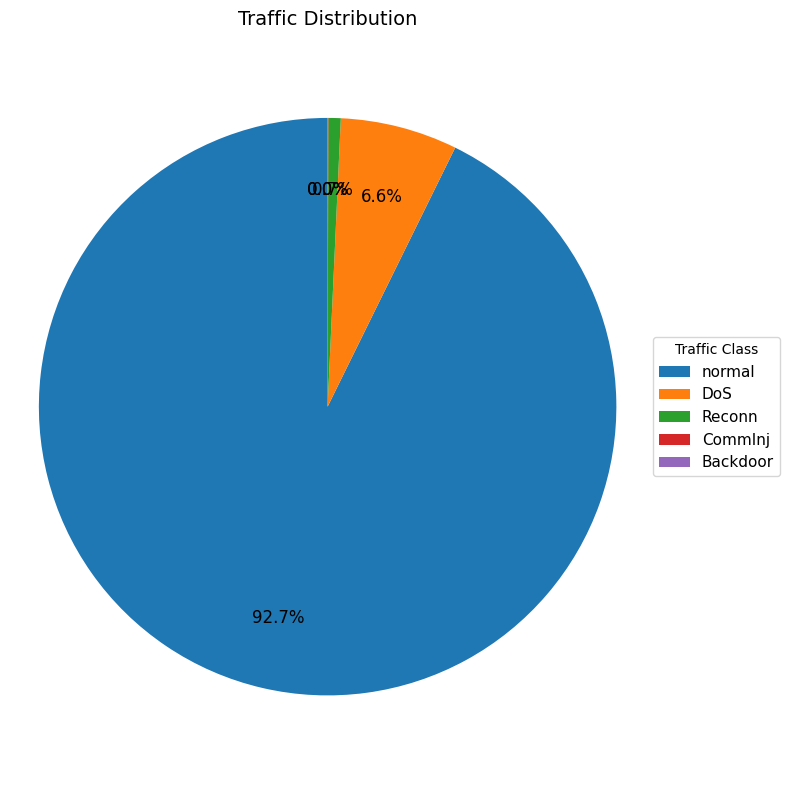

In [31]:

traffic_counts = full_data['Traffic'].value_counts()

plt.figure(figsize=(8, 8))

wedges, texts, autotexts = plt.pie(
    traffic_counts.values,
    labels=None,                
    autopct='%1.1f%%',           
    startangle=90,
    pctdistance=0.75,
    textprops={'fontsize': 12}
)

# Add clean legend with class names
plt.legend(
    wedges,
    traffic_counts.index,
    title="Traffic Class",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=11
)

plt.title("Traffic Distribution", fontsize=14)
plt.axis('equal')              
plt.tight_layout()
plt.savefig("/kaggle/working/traffic_distribution_PiChart.png", dpi=300, bbox_inches="tight")
plt.show()

# Bar Plot

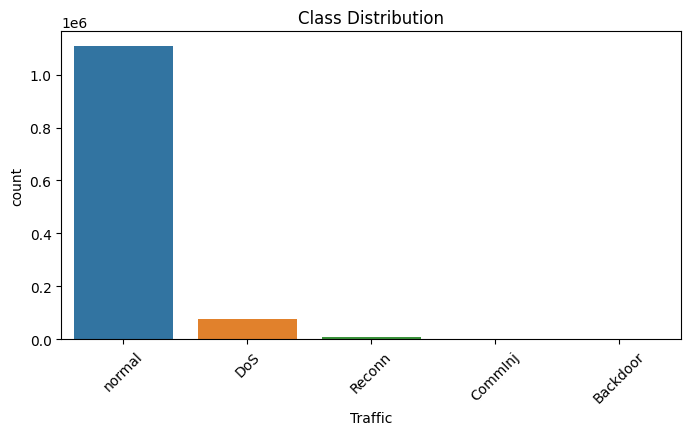

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(data=full_data, x='Traffic', order=full_data['Traffic'].value_counts().index)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.savefig("/kaggle/working/class_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

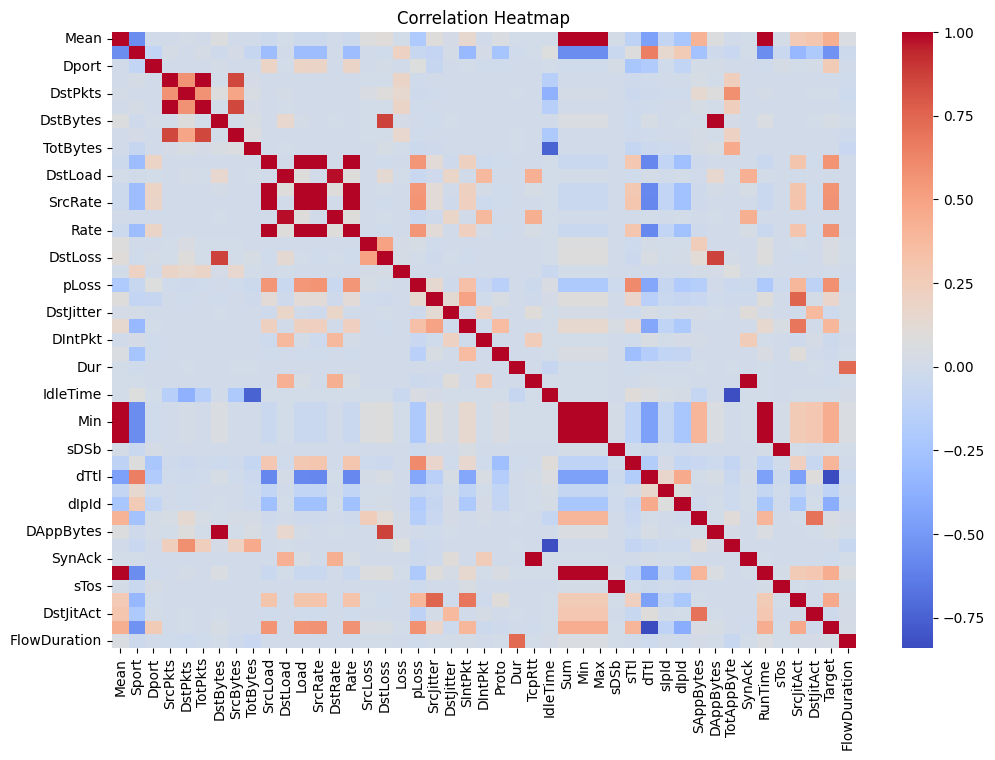

In [33]:
corr = full_data.corr(numeric_only=True)

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.savefig("/kaggle/working/correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

In [34]:
full_data['Target'].value_counts()
full_data['Target'].value_counts(normalize=True) * 100

Target
0    92.715059
1     7.284941
Name: proportion, dtype: float64

In [35]:
full_data['Traffic'].value_counts()
full_data['Traffic'].value_counts(normalize=True) * 100

Traffic
normal      92.715059
DoS          6.555660
Reconn       0.689849
CommInj      0.021683
Backdoor     0.017749
Name: proportion, dtype: float64

In [36]:
# Check total NaN values after cleansing
total_nans = full_data.isna().sum().sum()
print("Total NaN values after cleansing:", total_nans)

Total NaN values after cleansing: 0


# 2. Numerical Data

### a. Histogram

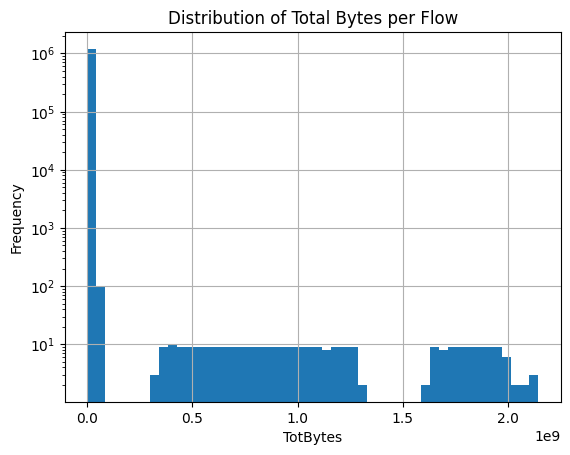

In [37]:
# Histogram for TotBytes
full_data['TotBytes'].hist(bins=50)
plt.title("Distribution of Total Bytes per Flow")
plt.xlabel("TotBytes")
plt.ylabel("Frequency")
plt.yscale('log')  # log scale helps if heavily skewed
# Save to Kaggle working directory
plt.savefig("/kaggle/working/totbytes_hist.png", dpi=300, bbox_inches="tight")
plt.show()

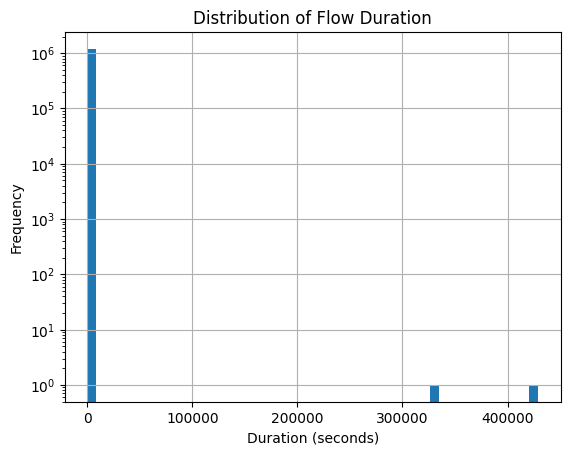

In [38]:
# Histogram for Dur (Duration)
full_data['Dur'].hist(bins=50)
plt.title("Distribution of Flow Duration")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.yscale('log')
plt.savefig("/kaggle/working/flow_duration_hist.png", dpi=300, bbox_inches="tight")
plt.show()

# b. BoxPlot

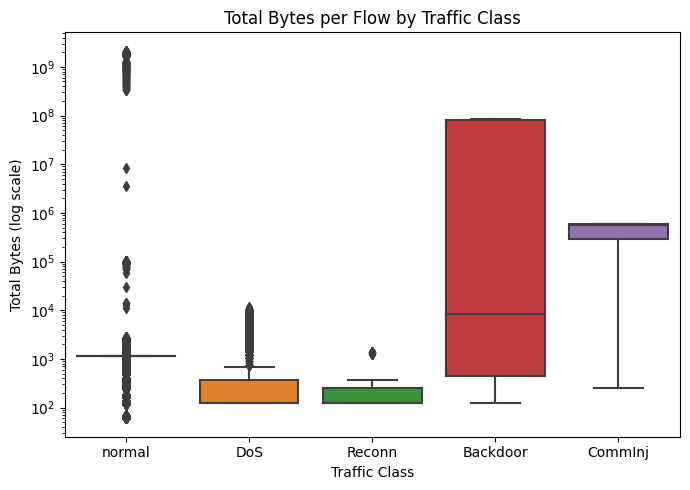

In [39]:
plt.figure(figsize=(7,5))
sns.boxplot(data=full_data, x='Traffic', y='TotBytes')
plt.yscale('log')  # bytes can span many orders of magnitude
plt.title("Total Bytes per Flow by Traffic Class")
plt.xlabel("Traffic Class")
plt.ylabel("Total Bytes (log scale)")
plt.tight_layout()
# Save to Kaggle working directory
plt.savefig("/kaggle/working/totbytes_boxplot_by_traffic.png", dpi=300, bbox_inches="tight")
plt.show()

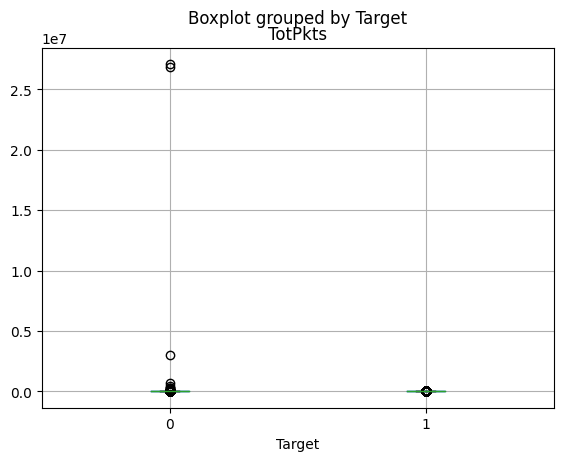

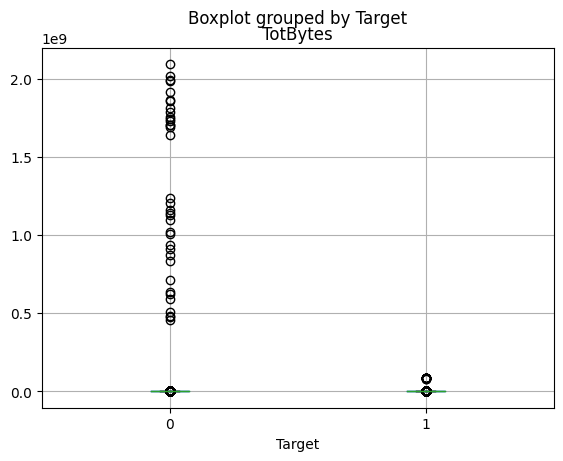

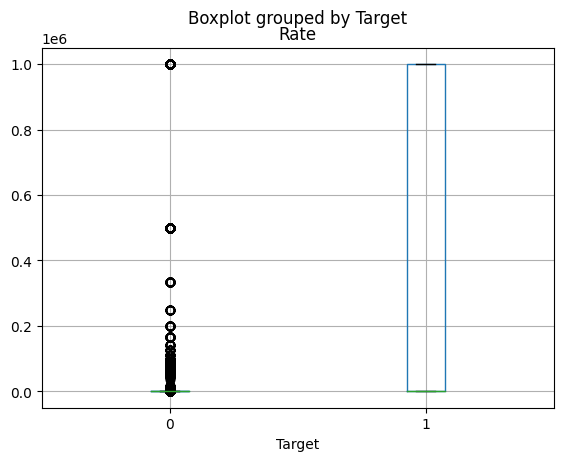

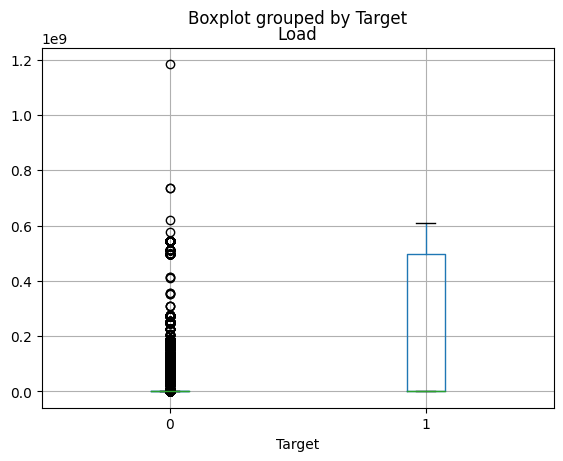

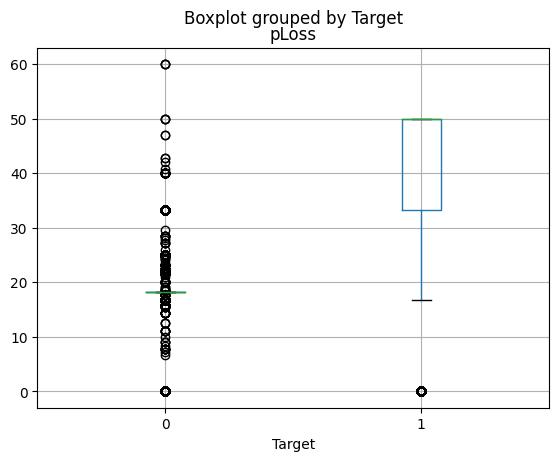

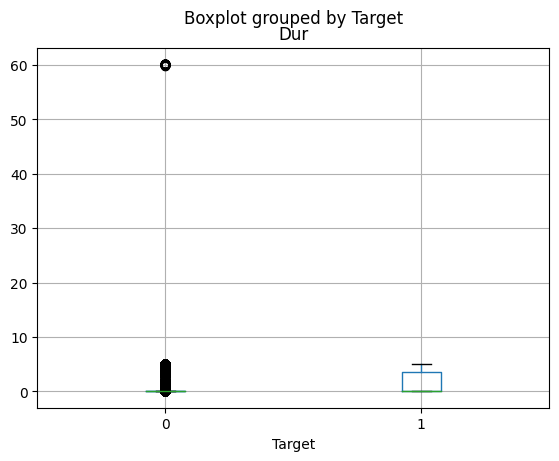

In [40]:
for col in key_features:
    full_data.sample(200000).boxplot(column=col, by='Target')
    plt.title(col)
    plt.show()

# Distributions and skewness

TotPkts skewness: 480.80440801266275


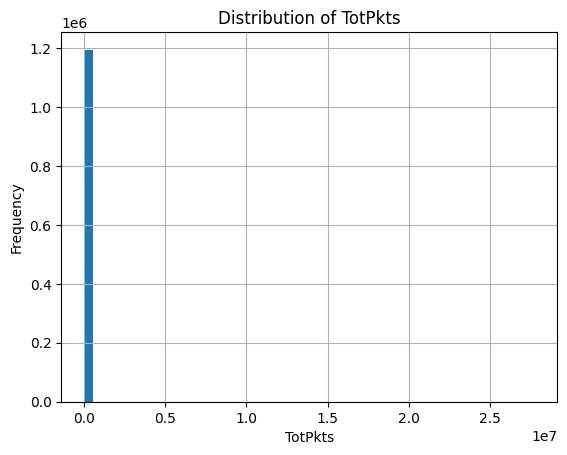

TotBytes skewness: 81.03905276598579


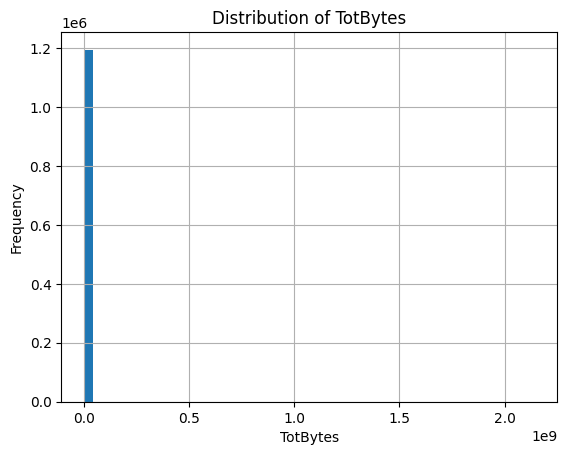

Rate skewness: 5.452960869162655


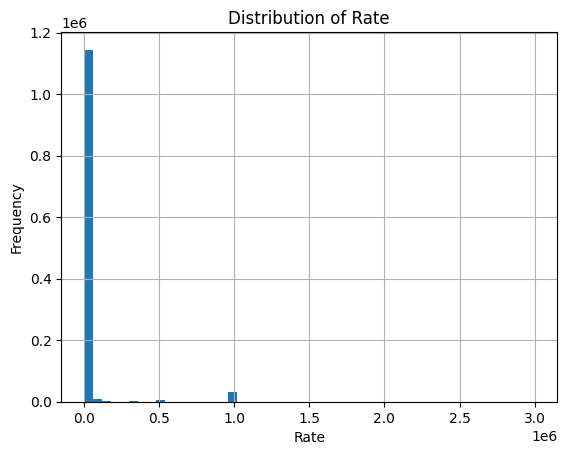

Load skewness: 5.435630152270119


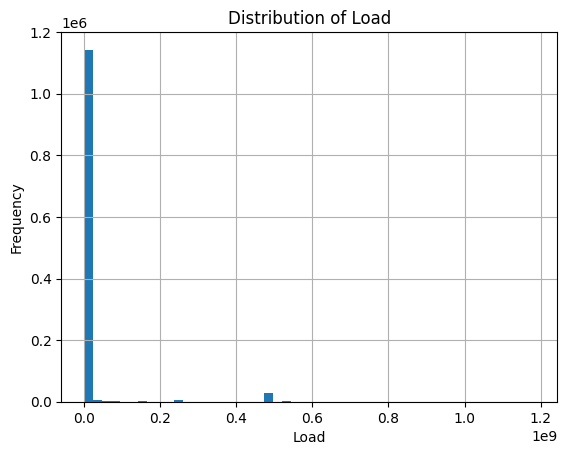

Dur skewness: 792.1594647212171


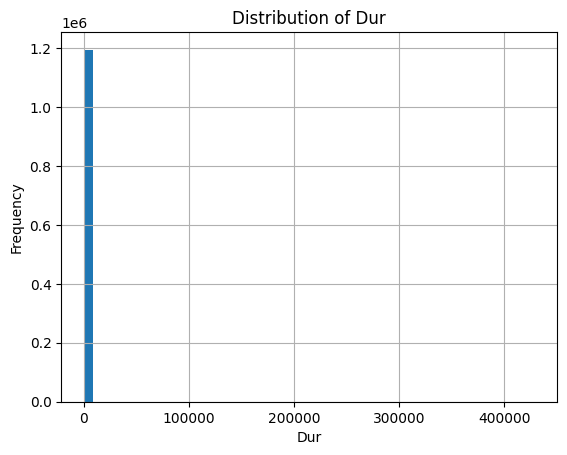

IdleTime skewness: -53.11096633516178


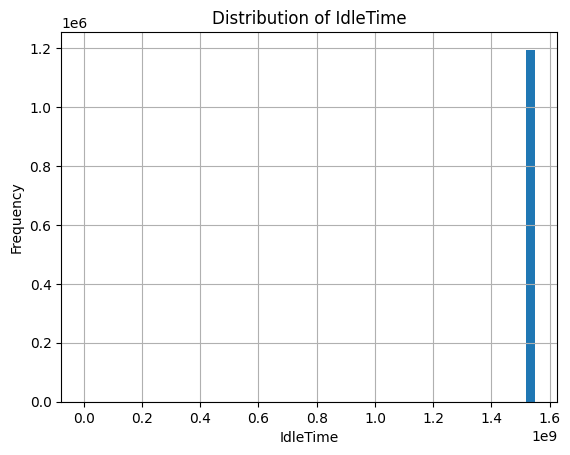

FlowDuration skewness: 1032.1175841678246


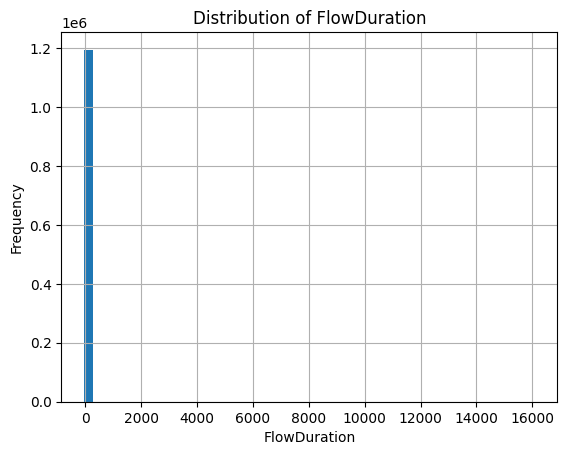

In [41]:
key_cols = ['TotPkts', 'TotBytes', 'Rate', 'Load', 'Dur', 'IdleTime', 'FlowDuration']

for col in key_cols:
    print(f"{col} skewness: {full_data[col].skew()}")
    full_data[col].hist(bins=50)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Multivariate Analysis (Feature vs Target)

# Scatter Plot

In [ ]:
sns.scatterplot(data=full_data.sample(5000), x='SrcBytes', y='DstBytes', hue='Traffic')
plt.title("Source vs Destination Bytes by Class")
plt.show()

# Data wrangling/cleansing

In [42]:
full_data = full_data.drop(columns=['StartTime', 'LastTime', 'SrcAddr', 'DstAddr', 'sIpId', 'dIpId'])
full_data.head()

,Mean,Sport,Dport,SrcPkts,DstPkts,TotPkts,DstBytes,SrcBytes,TotBytes,SrcLoad,...,DAppBytes,TotAppByte,SynAck,RunTime,sTos,SrcJitAct,DstJitAct,Traffic,Target,FlowDuration
0,0,59034,502,10,8,18,508,644,1152,87486.093750,...,20,44,0.001176,0.053037,0,0.000000,0.0,normal,0,0.0
1,0,55841,502,10,8,18,508,644,1152,88077.296875,...,20,44,0.001308,0.052681,0,0.000000,0.0,normal,0,0.0
2,0,63774,502,10,8,18,508,644,1152,89587.390625,...,20,44,0.000690,0.051793,0,0.000000,0.0,normal,0,0.0
3,0,61771,80,4,0,4,0,248,248,1672.746582,...,0,0,0.000000,0.889555,0,419.338813,0.0,DoS,1,1.0
4,3,0,0,14,0,14,0,868,868,1842.256714,...,0,476,0.000000,3.500055,0,525.146562,0.0,normal,0,4.0


In [43]:
!pip install -r /kaggle/input/setup-file/updated-requirements.txt
#!pip install scipy==1.11.3
!pip install pytorch-widedeep
!pip install pytorch-metric-learning
!pip install faiss-cpu
#!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.5/395.5 kB 6.4 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 22.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 76.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 57.7 MB/s eta 0:00:0000:0100:01
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package

In [44]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
from pytorch_widedeep import Trainer
from pytorch_widedeep.models import TabMlp, TabMlpDecoder
from pytorch_widedeep.preprocessing import TabPreprocessor
from pytorch_widedeep.self_supervised_training import EncoderDecoderTrainer
from pytorch_widedeep.callbacks import EarlyStopping
from pytorch_widedeep.metrics import Accuracy

from pytorch_metric_learning import miners,losses

2025-12-08 23:15:09.933519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765235710.321549      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765235710.435187      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [45]:
import time
import pickle
#import faiss
import pandas as pd
import numpy as np
import torch
import torchvision.utils
import torch.nn as nn
import torch.optim as torch_optim
from torch.utils.data import DataLoader, Dataset
import sys
sys.path.insert(1, '/kaggle/input/setup-file/')
from pytorchtools import EStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
#path = '/kaggle/input/setup-file/'
#full_data = pd.read_csv(path+"wustl_iiot_2021.csv")
#full_data = full_data.drop(columns=['StartTime', 'LastTime', 'SrcAddr', 'DstAddr', 'sIpId', 'dIpId'])
full_data.head()

,Mean,Sport,Dport,SrcPkts,DstPkts,TotPkts,DstBytes,SrcBytes,TotBytes,SrcLoad,...,DAppBytes,TotAppByte,SynAck,RunTime,sTos,SrcJitAct,DstJitAct,Traffic,Target,FlowDuration
0,0,59034,502,10,8,18,508,644,1152,87486.093750,...,20,44,0.001176,0.053037,0,0.000000,0.0,normal,0,0.0
1,0,55841,502,10,8,18,508,644,1152,88077.296875,...,20,44,0.001308,0.052681,0,0.000000,0.0,normal,0,0.0
2,0,63774,502,10,8,18,508,644,1152,89587.390625,...,20,44,0.000690,0.051793,0,0.000000,0.0,normal,0,0.0
3,0,61771,80,4,0,4,0,248,248,1672.746582,...,0,0,0.000000,0.889555,0,419.338813,0.0,DoS,1,1.0
4,3,0,0,14,0,14,0,868,868,1842.256714,...,0,476,0.000000,3.500055,0,525.146562,0.0,normal,0,4.0


In [47]:
# Drop Traffic and Target columns from features (X)
unlabeled_features = full_data.drop(['Traffic', 'Target'], axis=1)

# Separate Target column as labels (y)
y_labels = full_data['Target']

In [48]:
y_true_labels =full_data['Target'].reset_index(drop=True)

In [49]:
train_data, test_data = train_test_split(unlabeled_features, test_size=0.2, shuffle=True)
train_data, val_data = train_test_split(train_data, test_size=0.1, shuffle=True)

In [50]:
# Match length of train_data
y_true_labels= y_true_labels.iloc[:len(train_data)].reset_index(drop=True)

In [51]:
print(f"Train Data Shape: {train_data.shape}")
print(f"Validation Data Shape: {val_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

Train Data Shape: (860013, 42)
Validation Data Shape: (95558, 42)
Test Data Shape: (238893, 42)


In [52]:
# Preprocessing Setup
cat_embed_cols = ['Proto']
continuous_cols = [
    'Mean', 'Sport', 'Dport', 'SrcPkts', 'DstPkts', 'TotPkts', 'DstBytes',
    'SrcBytes', 'TotBytes', 'SrcLoad', 'DstLoad', 'Load', 'SrcRate',
    'DstRate', 'Rate', 'SrcLoss', 'DstLoss', 'Loss', 'pLoss', 'SrcJitter',
    'DstJitter', 'SIntPkt', 'DIntPkt', 'Dur', 'TcpRtt', 'IdleTime',
    'Sum', 'Min', 'Max', 'sDSb', 'sTtl', 'dTtl', 'SAppBytes', 'DAppBytes',
    'TotAppByte', 'SynAck', 'RunTime', 'sTos', 'SrcJitAct', 'DstJitAct'
]

In [53]:
# Initialize TabPreprocessor
tab_preprocessor = TabPreprocessor(
    cat_embed_cols=cat_embed_cols,
    continuous_cols=continuous_cols,
    cols_to_scale=continuous_cols
)

# Phase 1: Self-Supervised Pretraining

In [54]:
X_unlabeled = train_data
X_tab_unlabeled = tab_preprocessor.fit_transform(X_unlabeled)

In [55]:
enc = TabMlp(
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=tab_preprocessor.continuous_cols,
    mlp_hidden_dims=[200, 100],
    mlp_dropout=0.1,
    mlp_activation='tanh',
    mlp_batchnorm=True
)
enc

TabMlp(
  (cat_embed): DiffSizeCatEmbeddings(
    (embed_layers): ModuleDict(
      (emb_layer_Proto): Embedding(9, 5, padding_idx=0)
    )
    (embedding_dropout): Dropout(p=0.0, inplace=False)
  )
  (cont_norm): Identity()
  (encoder): MLP(
    (mlp): Sequential(
      (dense_layer_0): Sequential(
        (0): Linear(in_features=45, out_features=200, bias=False)
        (1): Tanh()
        (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (dense_layer_1): Sequential(
        (0): Linear(in_features=200, out_features=100, bias=True)
        (1): Tanh()
        (2): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

In [56]:
dec = TabMlpDecoder(
    embed_dim=45,
    mlp_hidden_dims=[100, 200],
    mlp_activation='tanh',
    mlp_dropout=0.1,
    mlp_batchnorm=True
)

In [57]:
optim_p1 = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=0.001)
scheduler_p1 = torch.optim.lr_scheduler.StepLR(optim_p1, step_size=5)

In [58]:
encoder_decoder_trainer = EncoderDecoderTrainer(
    encoder=enc,
    decoder=dec,
    optimizer=optim_p1,
    lr_scheduler=scheduler_p1,
    callbacks=[EarlyStopping(monitor='train_loss', patience=5)],
    num_workers=0,
    device='cuda'
)

In [59]:
# Start the timer
start_time = time.time()

encoder_decoder_trainer.pretrain(X_tab_unlabeled, n_epochs=100, batch_size=32768)

# Calculate the total training time
end_time = time.time()
total_time = end_time - start_time
print(f"Total pre-training time: {total_time:.2f} seconds")

epoch 17: 100%|██████████| 27/27 [00:08<00:00,  3.23it/s, loss=22.5]

Total pre-training time: 145.30 seconds


In [60]:
# Save Pretrained Encoder
# Save the tab_preprocessor
with open("tab_preproc-1.pkl", "wb") as dp:
    pickle.dump(tab_preprocessor, dp)
    # Save the encoder model state
torch.save(enc.state_dict(), "enc_p1-1.pt")
print("Files saved: tab_preproc-1.pkl and enc_p1-1.pt")

Files saved: tab_preproc-1.pkl and enc_p1-1.pt


# Clustering with unlabled dataset

In [61]:
# Select GPU ("cuda") if available, otherwise default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print which device is being used
print(device)

cuda


In [62]:
# Save a copy of the model’s initial weights before training
initial_weights = {name: param.clone() for name, param in enc.named_parameters()}

In [63]:
# Training setup
epoch_num = 100           # Max number of epochs to train
lr = 0.01                 # Learning rate for optimizer
wd = 1e-6                 # Weight decay (L2 regularization)
debug = False             # Debug flag (can be used for extra logging)
patience = 5              # Early stopping patience (stop if no val improvement for 5 epochs)
trained_model_name = "enc_p2-2.pt"  # File name for saving the trained model

In [64]:
# Transform the selected 20% labeled data
X_unlabeled_tab = tab_preprocessor.transform(X_unlabeled)
X_unlabeled_tab_tensor = torch.tensor(X_unlabeled_tab).to(device)

In [65]:
# Generate embeddings using the fine-tuned encoder
X_unlabeled_emb = enc(X_unlabeled_tab_tensor).to(device)

In [66]:
# Convert embeddings to numpy arrays
X_unlabeled_emb_np = X_unlabeled_emb.cpu().detach().numpy()

In [67]:
# --- K-Means clustering on learned embeddings ---
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score


# Set number of clusters:
# - If you want "class-like" clusters, use 5 for your 5 traffic types
# - If you want anomaly-vs-normal only, use 2
N_CLUSTERS = 5

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)  # n_init=10 for broad sklearn compat
clusters = kmeans.fit_predict(X_unlabeled_emb_np)

print(f"[KMeans] inertia={kmeans.inertia_:.2f}  |  clusters shape={clusters.shape}")

[KMeans] inertia=3590911.50  |  clusters shape=(860013,)


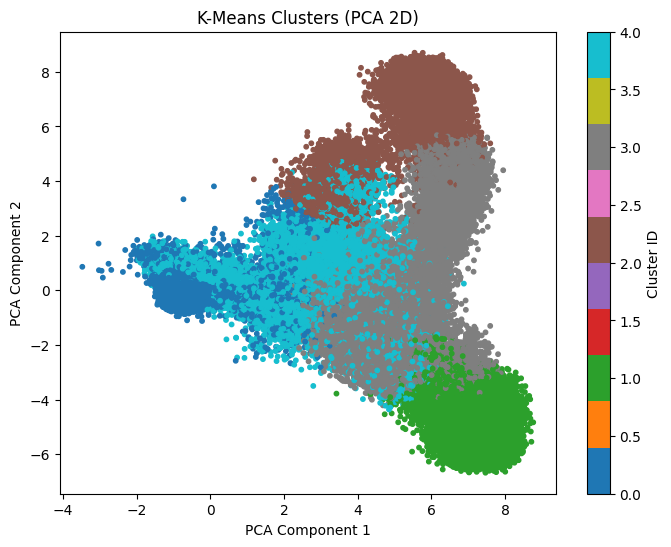

In [68]:
from sklearn.decomposition import PCA

# Reduce to 2 dimensions for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_unlabeled_emb_np)

# Plot the clusters
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', s=10)
plt.title("K-Means Clusters (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster ID')
plt.savefig("/kaggle/working/kmeans_Cluster.png", dpi=300, bbox_inches="tight")
plt.show()

In [69]:
import joblib

# after fitting:
joblib.dump(kmeans, "kmeans_model.pkl")   # saves to current working directory

['kmeans_model.pkl']

In [70]:
# X_unlabeled_emb_np: (n_unlabeled, d) —  unlabeled embeddings
labels_unl = kmeans.predict(X_unlabeled_emb_np)  # integer cluster IDs
print("Unlabeled cluster counts:", np.bincount(labels_unl))

Unlabeled cluster counts: [776395  26761  22370  23167  11320]


In [71]:

#  attach numeric cluster IDs to the original unlabeled rows
unlabeled_data = X_unlabeled.copy()          # keep original safe
unlabeled_data["cluster_id"] = clusters         # same order/length

#  define your pseudo names (one for each integer cluster)
pseudo_map = {
    0: "Normal",
    1: "DoS",
    2: "Reconn",
    3: "CommInj",
    4: "Backdoor",
}  # adjust to match N_CLUSTERS

unlabeled_data["pseudo_label"] = unlabeled_data["cluster_id"].map(pseudo_map)

#  quick sanity check
print(unlabeled_data[["cluster_id", "pseudo_label"]].head())
print(unlabeled_data["pseudo_label"].value_counts())

         cluster_id pseudo_label
962815            3      CommInj
5795              1          DoS
1008670           0       Normal
217750            0       Normal
157853            0       Normal
pseudo_label
Normal      776395
DoS          26761
CommInj      23167
Reconn       22370
Backdoor     11320
Name: count, dtype: int64


In [72]:
# Check Clusters Purity ----------
def cluster_purity(y_true_labels, cids):
    df = pd.DataFrame({"y": y_true_labels, "c": clusters})
    ct = df.value_counts(["c", "y"]).rename("count").reset_index()
    max_per_cluster = ct.groupby("c")["count"].max()
    return max_per_cluster.sum() / len(df)

purity = cluster_purity(y_true_labels, clusters)
print(f"[Purity] {purity:.4f}  (higher is better; in (0,1]]")

[Purity] 0.9272  (higher is better; in (0,1]]


# LightGBM (fast + great on large imbalanced tabular)

In [73]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation
import joblib

# =========================
LightGBM on pseudo labels
=========================

In [74]:
# ----------- Inputs -----------
# Embeddings (n_samples, n_features)
X = X_unlabeled_emb_np.astype(np.float32)
# Pseudo-labels (strings like "Normal","DoS",...)
y_str = unlabeled_data["pseudo_label"].values

In [75]:
# -----------  Label encode -----------
le = LabelEncoder()
y = le.fit_transform(y_str)            # ints 0..C-1
class_names = le.classes_
print("Classes:", list(class_names))

Classes: ['Backdoor', 'CommInj', 'DoS', 'Normal', 'Reconn']


In [76]:
# Optional: filter out any rows with missing pseudo labels
mask_valid = pd.notna(y_str)
X = X[mask_valid]
y_str = y_str[mask_valid]

In [77]:
# -----------  Stratified split -----------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train size:", X_train.shape, "Val size:", X_val.shape)

Train size: (688010, 100) Val size: (172003, 100)


In [78]:
# -----------  LightGBM config -----------
lgbm = LGBMClassifier(
    objective="multiclass",     # auto works too, but explicit is nice
    n_estimators=4000,          # large cap + early stopping
    learning_rate=0.03,
    num_leaves=128,
    max_depth=-1,
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    class_weight="balanced",    # handle pseudo-label imbalance
    n_jobs=-1,
    random_state=42
)

In [79]:
# -----------  Train with early stopping (new API) -----------
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="multi_logloss",
    callbacks=[
        early_stopping(stopping_rounds=150),   # <— replaces early_stopping_rounds
       # log_evaluation(300)                    # print every 100 rounds
    ]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.400868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 688010, number of used features: 100
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 150 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.03, n_estimators=4000, n_jobs=-1, num_leaves=128,
               objective='multiclass', random_state=42, reg_lambda=1.0,
               subsample=0.8, subsample_freq=1)

In [80]:
# -----------  Evaluate -----------
y_pred = lgbm.predict(X_val)
y_proba = lgbm.predict_proba(X_val)

bal_acc = balanced_accuracy_score(y_val, y_pred)
print(f"\nBalanced Accuracy: {bal_acc:.4f}\n")
print("Classification report (val):")

print(classification_report(y_val, y_pred, target_names=class_names, digits=4))
# Save as PNG (exact text appearance)
plt.savefig("classification_report_LGBM_val.png",dpi=500,bbox_inches="tight"
)
plt.close()


Balanced Accuracy: 0.9938

Classification report (val):
              precision    recall  f1-score   support

    Backdoor     0.9664    0.9920    0.9791      2264
     CommInj     0.9842    0.9944    0.9893      4634
         DoS     0.9972    0.9957    0.9964      5352
      Normal     0.9999    0.9993    0.9996    155279
      Reconn     0.9893    0.9877    0.9885      4474

    accuracy                         0.9987    172003
   macro avg     0.9874    0.9938    0.9906    172003
weighted avg     0.9987    0.9987    0.9987    172003



In [81]:
# Confusion matrix (counts)
cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in class_names],
                        columns=[f"pred_{c}" for c in class_names])
print("\nConfusion matrix (val):\n", cm_df)
plt.savefig("Confusion_matrix_LGBM_val.png", dpi=500, bbox_inches='tight')


Confusion matrix (val):
                pred_Backdoor  pred_CommInj  pred_DoS  pred_Normal  pred_Reconn
true_Backdoor           2246             7         6            5            0
true_CommInj               7          4608         9            6            4
true_DoS                   9            14      5329            0            0
true_Normal               55             5         0       155175           44
true_Reconn                7            48         0            0         4419


<Figure size 640x480 with 0 Axes>

In [82]:
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Validation)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.savefig("confusion_matrix_LGBM_val.png")   # Save as PNG image
plt.close()

In [83]:
# ----------- 6) Save artifacts -----------
joblib.dump(lgbm, "lgbm_pseudo_label.model")
joblib.dump(le,   "label_encoder.joblib")

['label_encoder.joblib']

# =========================
XGBoost on pseudo labels
=========================

In [84]:
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

In [85]:
# ----------- Inputs -----------
X = X_unlabeled_emb_np.astype(np.float32)
y_str = unlabeled_data["pseudo_label"].values

In [86]:
# -----------  Class-imbalance → per-sample weights -----------
cw = compute_class_weight(class_weight="balanced",
                          classes=np.arange(5),
                          y=y_train)#n_classes
# map y_train → weights
class_weight_map = dict(zip(range(5), cw))
sample_weight = np.array([class_weight_map[c] for c in y_train], dtype=np.float32)

print("Class weights:", {cls: round(w, 3) for cls, w in zip(class_names, cw)})


Class weights: {'Backdoor': 15.195, 'CommInj': 7.425, 'DoS': 6.427, 'Normal': 0.222, 'Reconn': 7.689}


In [87]:
# -----------  XGBoost model (multiclass) -----------

xgb_clf = xgb.XGBClassifier(
    objective="multi:softprob",   # probabilities for multiclass
    num_class=5, #n_classes
    n_estimators=4000,            # large cap; rely on early stopping
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    tree_method="gpu_hist",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

In [88]:
# -----------  Train with early stopping -----------
xgb_clf.fit(
    X_train, y_train,
    sample_weight=sample_weight,            # handles imbalance
    eval_set=[(X_val, y_val)],
    verbose=100,                            # log every 100 iters
    early_stopping_rounds=150               # stop when no val improvement
)



/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [23:23:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:1.48757
[100]	validation_0-mlogloss:0.01326
[200]	validation_0-mlogloss:0.00431
[300]	validation_0-mlogloss:0.00386
[400]	validation_0-mlogloss:0.00378
[500]	validation_0-mlogloss:0.00376
[600]	validation_0-mlogloss:0.00373
[700]	validation_0-mlogloss:0.00372
[800]	validation_0-mlogloss:0.00370
[900]	validation_0-mlogloss:0.00369
[1000]	validation_0-mlogloss:0.00368
[1100]	validation_0-mlogloss:0.00367
[1200]	validation_0-mlogloss:0.00366
[1300]	validation_0-mlogloss:0.00365
[1400]	validation_0-mlogloss:0.00365
[1500]	validation_0-mlogloss:0.00364
[1600]	validation_0-mlogloss:0.00363
[1700]	validation_0-mlogloss:0.00363
[1800]	validation_0-mlogloss:0.00363
[1900]	validation_0-mlogloss:0.00363
[2000]	validation_0-mlogloss:0.00362
[2100]	validation_0-mlogloss:0.00362
[2200]	validation_0-mlogloss:0.00361
[2300]	validation_0-mlogloss:0.00361
[2400]	validation_0-mlogloss:0.00360
[2500]	validation_0-mlogloss:0.00360
[2600]	validation_0-mlogloss:0.00360
[2700]	valida

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=4000,
              n_jobs=-1, num_class=5, num_parallel_tree=None, ...)

In [89]:
# -----------  Evaluate -----------
y_pred = xgb_clf.predict(X_val)
y_proba = xgb_clf.predict_proba(X_val)

bal_acc = balanced_accuracy_score(y_val, y_pred)
print(f"\nBalanced Accuracy: {bal_acc:.4f}\n")
print("Classification report (val):")
plt.savefig("Classification_report_XGB_val.png", dpi=500, bbox_inches='tight')
print(classification_report(y_val, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in class_names],
                        columns=[f"pred_{c}" for c in class_names])
print("\nConfusion matrix (val):\n", cm_df)
plt.savefig("Confusion_matrix_XGB_val.png", dpi=500, bbox_inches='tight')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [23:27:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [23:27:38] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



Balanced Accuracy: 0.9946

Classification report (val):
              precision    recall  f1-score   support

    Backdoor     0.9723    0.9912    0.9816      2264
     CommInj     0.9876    0.9950    0.9913      4634
         DoS     0.9972    0.9972    0.9972      5352
      Normal     0.9999    0.9995    0.9997    155279
      Reconn     0.9919    0.9899    0.9909      4474

    accuracy                         0.9989    172003
   macro avg     0.9898    0.9946    0.9921    172003
weighted avg     0.9989    0.9989    0.9989    172003


Confusion matrix (val):
                pred_Backdoor  pred_CommInj  pred_DoS  pred_Normal  pred_Reconn
true_Backdoor           2244             7         5            7            1
true_CommInj               5          4611        10            6            2
true_DoS                   9             6      5337            0            0
true_Normal               45             5         0       155196           33
true_Reconn                5     

<Figure size 640x480 with 0 Axes>

In [90]:
# ----------- Save artifacts -----------
xgb_clf.save_model("xgb_pseudo_label.json")   # native XGBoost format
joblib.dump(le, "label_encoder.joblib")

# ----------- 8) Predict on ALL data (optional) -----------
best_ntree = getattr(xgb_clf, "best_iteration", None)
if best_ntree is not None:
    xgb_clf.set_params(n_estimators=best_ntree)

preds_all = xgb_clf.predict(X)
probs_all = xgb_clf.predict_proba(X)

out_df = unlabeled_data.loc[mask_valid].copy()
out_df["xgb_pred"] = le.inverse_transform(preds_all)
out_df["xgb_conf"] = probs_all.max(axis=1)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [23:27:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [91]:
# =====  Predict on ALL valid rows using best iteration (if available) =====
X_full = X_unlabeled_emb_np[mask_valid].astype(np.float32)

best_iter = getattr(xgb_clf, "best_iteration", None)

if best_iter is not None:
    # Newer XGBoost: use iteration_range to respect best_iteration
    all_preds = xgb_clf.predict(X_full, iteration_range=(0, best_iter + 1))
    all_probs = xgb_clf.predict_proba(X_full, iteration_range=(0, best_iter + 1))
else:
    # Fallback: no early stopping info
    all_preds = xgb_clf.predict(X_full)
    all_probs = xgb_clf.predict_proba(X_full)

unlabeled_data.loc[mask_valid, "xgb_pred"] = le.inverse_transform(all_preds)
unlabeled_data.loc[mask_valid, "xgb_conf"] = all_probs.max(axis=1)

 
# =========================
DBSCAN on pseudo labels
=========================

In [92]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)
import numpy as np

# Use the latent embeddings as input (already defined)
X_dbscan = X_unlabeled_emb_np.astype(np.float32)

# DBSCAN hyperparameters (you will likely tune eps/min_samples)
eps = 0.5        # neighborhood radius
min_samples = 10 # minimum points to form a dense region

print(f"DBSCAN setup -> eps={eps}, min_samples={min_samples}, X shape={X_dbscan.shape}")

DBSCAN setup -> eps=0.5, min_samples=10, X shape=(860013, 100)


In [93]:
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(X_dbscan)

# DBSCAN labels: -1 = noise, 0..K-1 = clusters
unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
print("DBSCAN cluster labels (including noise):")
for lbl, cnt in zip(unique_labels, counts):
    print(f"  label={lbl:2d}  count={cnt}")

DBSCAN cluster labels (including noise):
  label=-1  count=823839
  label= 0  count=33004
  label= 1  count=925
  label= 2  count=839
  label= 3  count=878
  label= 4  count=18
  label= 5  count=21
  label= 6  count=14
  label= 7  count=11
  label= 8  count=21
  label= 9  count=9
  label=10  count=10
  label=11  count=12
  label=12  count=26
  label=13  count=21
  label=14  count=12
  label=15  count=10
  label=16  count=12
  label=17  count=28
  label=18  count=11
  label=19  count=10
  label=20  count=20
  label=21  count=10
  label=22  count=8
  label=23  count=12
  label=24  count=13
  label=25  count=12
  label=26  count=15
  label=27  count=11
  label=28  count=10
  label=29  count=11
  label=30  count=11
  label=31  count=16
  label=32  count=10
  label=33  count=11
  label=34  count=10
  label=35  count=10
  label=36  count=10
  label=37  count=10
  label=38  count=16
  label=39  count=10
  label=40  count=21
  label=41  count=9
  label=42  count=6
  label=43  count=10


In [94]:
#  Evaluate DBSCAN clustering against pseudo-labels

# Mask to ignore noise points (-1) for ARI/NMI comparison
mask = dbscan_labels != -1

num_noise = np.sum(dbscan_labels == -1)
print("Number of noise points:", num_noise)

# ARI and NMI (only on non-noise samples)
if np.sum(mask) > 0:
    ari = adjusted_rand_score(y[mask], dbscan_labels[mask])
    nmi = normalized_mutual_info_score(y[mask], dbscan_labels[mask])
    print(f"[DBSCAN] ARI: {ari:.4f}")
    print(f"[DBSCAN] NMI: {nmi:.4f}")
else:
    print("Not enough non-noise points for ARI/NMI computation.")

# Silhouette score (only meaningful if >1 cluster and not all noise)
unique_core_labels = np.unique(dbscan_labels[mask])
if len(unique_core_labels) > 1:
    sil = silhouette_score(X_dbscan[mask], dbscan_labels[mask])
    print(f"[DBSCAN] Silhouette Score: {sil:.4f}")
else:
    print("Silhouette score not defined (only one cluster or all noise).")

Number of noise points: 823839
[DBSCAN] ARI: 0.0000
[DBSCAN] NMI: 0.0000
[DBSCAN] Silhouette Score: -0.0633
